In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from itertools import permutations, product, combinations
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler

# Settings

In [3]:
analyses = ["Fastcore", "gimme", "iMAT", "init", "tinit"]

In [4]:
n_components= 2
perplexity = 30 # 30.0

## Read the data

In [5]:
all_models = []
MEMs = []

for i,analysis in enumerate(analyses):       
    if analysis == "Fastcore":
        df = pd.read_csv("data\\"+analysis+"_rxnMatrix.csv", sep=",")
        df = df.drop(columns='Unnamed: 0')
    else:
        df = pd.read_csv("data\\"+analysis+"_rxnMatrix.csv", sep=";")
    
    df.columns = ["rxns"] +list(df.columns)[1:]
    models = list(df.columns[1:])
    #print(df.columns)
    models = list(map(lambda x: x.split("_")[1].split(".")[0]+"_"+analysis, models))
    #print(len(models))
    MEMs.append(models)
    all_models += models
    
    
    if i == 0:
        df_full = df
    else:
        df_full = pd.merge(df_full, df)
           
models = all_models

In [6]:
M = np.transpose(df_full.values[:,1:])

### Grouping by genotype

In [7]:
# WT
genotype0 = ["GSM1405493","GSM1405505","GSM1405517", 
              "GSM1405489","GSM1405501","GSM1405513",
              "GSM1405485","GSM1405497","GSM1405509",
              "GSM1405494","GSM1405506","GSM1405518",
              "GSM1405490","GSM1405502","GSM1405514",
              "GSM1405486","GSM1405498","GSM1405510"]
genotype0 = list(map(lambda x: x[0] + "_" + x[1], product(genotype0, analyses)))

# KO
genotype1 = ["GSM1405495","GSM1405507","GSM1405519",
              "GSM1405491","GSM1405503","GSM1405515",
              "GSM1405487","GSM1405499","GSM1405511",
              "GSM1405496","GSM1405508","GSM1405520",
              "GSM1405492","GSM1405504","GSM1405516",
              "GSM1405488","GSM1405500","GSM1405512"]
genotype1 = list(map(lambda x: x[0] + "_" + x[1], product(genotype1, analyses)))

genotype = (genotype0, genotype1)

### Grouping by diet

In [8]:
# LFnC
diet0 = ["GSM1405485","GSM1405497","GSM1405509","GSM1405487","GSM1405499","GSM1405511",
         "GSM1405486","GSM1405498","GSM1405510","GSM1405488","GSM1405500","GSM1405512"]

diet0 = list(map(lambda x: x[0] + "_" + x[1], product(diet0, analyses)))

# HFnC
diet1 = ["GSM1405489","GSM1405501","GSM1405513","GSM1405491","GSM1405503","GSM1405515",
         "GSM1405490","GSM1405502","GSM1405514","GSM1405492","GSM1405504","GSM1405516"]

diet1 = list(map(lambda x: x[0] + "_" + x[1], product(diet1, analyses)))

# HFC - F
diet2 = ["GSM1405493","GSM1405505","GSM1405517","GSM1405495","GSM1405507","GSM1405519",
         "GSM1405494","GSM1405506","GSM1405518","GSM1405496","GSM1405508","GSM1405520"]

diet2 = list(map(lambda x: x[0] + "_" + x[1], product(diet2, analyses)))

diet = (diet0, diet1, diet2)

### Grouping by gender

In [9]:
# F
gender0 = ["GSM1405493","GSM1405505","GSM1405517",
           "GSM1405489","GSM1405501","GSM1405513",
           "GSM1405485","GSM1405497","GSM1405509",
           "GSM1405495","GSM1405507","GSM1405519",
           "GSM1405491","GSM1405503","GSM1405515",
           "GSM1405487","GSM1405499","GSM1405511"]

gender0 = list(map(lambda x: x[0] + "_" + x[1], product(gender0, analyses)))

# M
gender1 = ["GSM1405494","GSM1405506","GSM1405518",
           "GSM1405490","GSM1405502","GSM1405514",
           "GSM1405486","GSM1405498","GSM1405510",
           "GSM1405496","GSM1405508","GSM1405520",
           "GSM1405492","GSM1405504","GSM1405516",
           "GSM1405488","GSM1405500","GSM1405512"]

gender1 = list(map(lambda x: x[0] + "_" + x[1], product(gender1, analyses)))

gender = (gender0, gender1)

### Grouping

In [10]:
groups = {"MEM": MEMs, "genotype": genotype, "diet": diet, "gender": gender}
labels = {"MEM":analyses, "genotype": ("WT","KO"), "diet": ("LFnC", "HFnC", "HFC"), "gender": ("F","M")}

## Preprocessing

Remove the reactions that are always 0 or always 1

In [11]:
M = M[:,~np.all(M==0, axis=0)]
M = M[:,~np.all(M==1, axis=0)]

In [12]:
M = np.array(M, dtype=float)

Zero centering the rows

In [13]:
M = StandardScaler(with_mean=True, with_std=False).fit_transform(M) #centering only

## t-SNE

In [16]:
tSNE = TSNE(n_components=n_components, perplexity = perplexity,  n_iter=5000)
comps = tSNE.fit_transform(M)
df = pd.DataFrame(data = comps, columns = ['PC1', 'PC2', 'PC3'][:n_components])
df['model'] = models

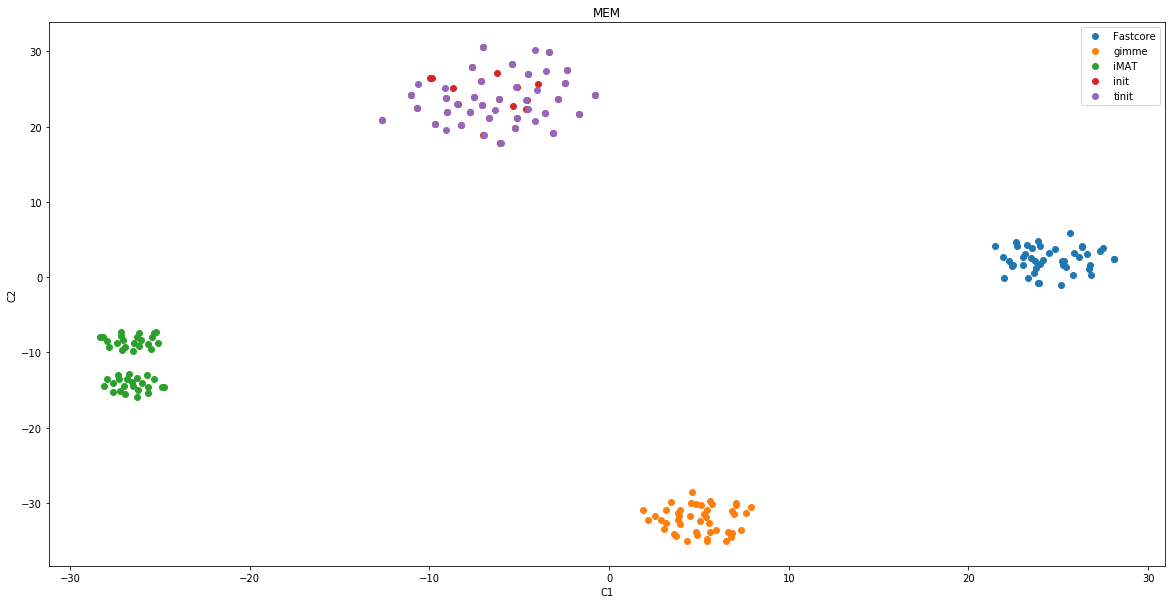

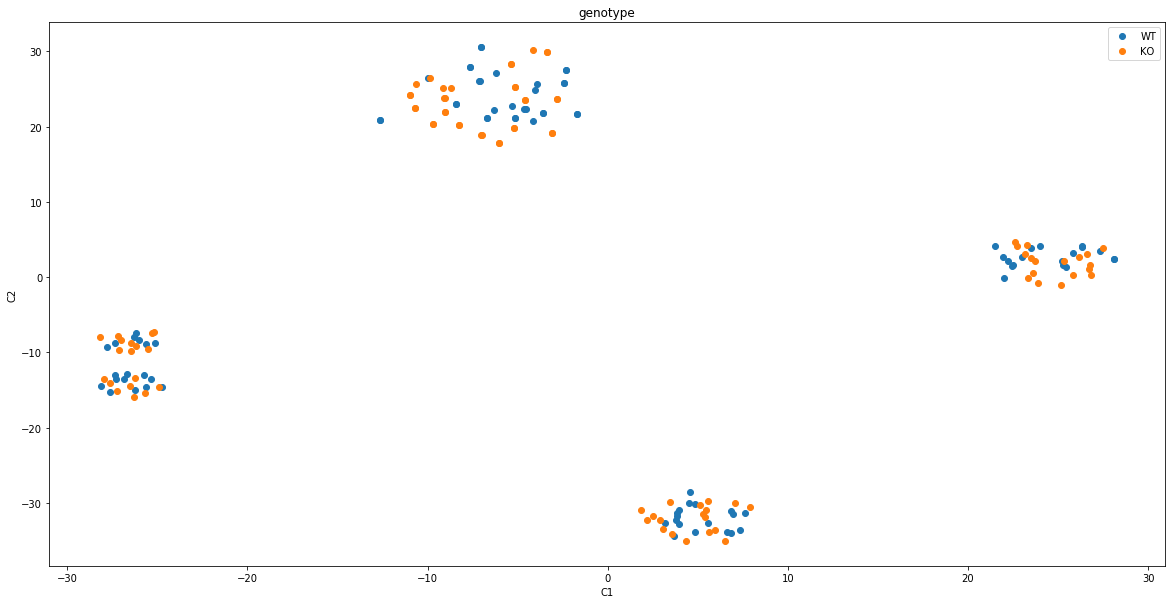

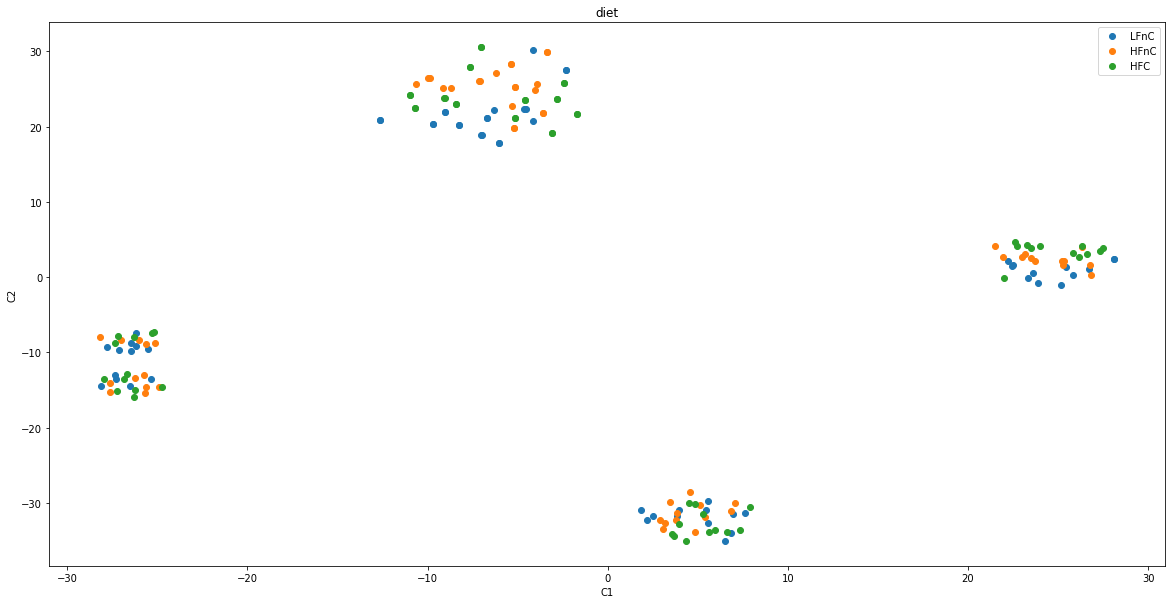

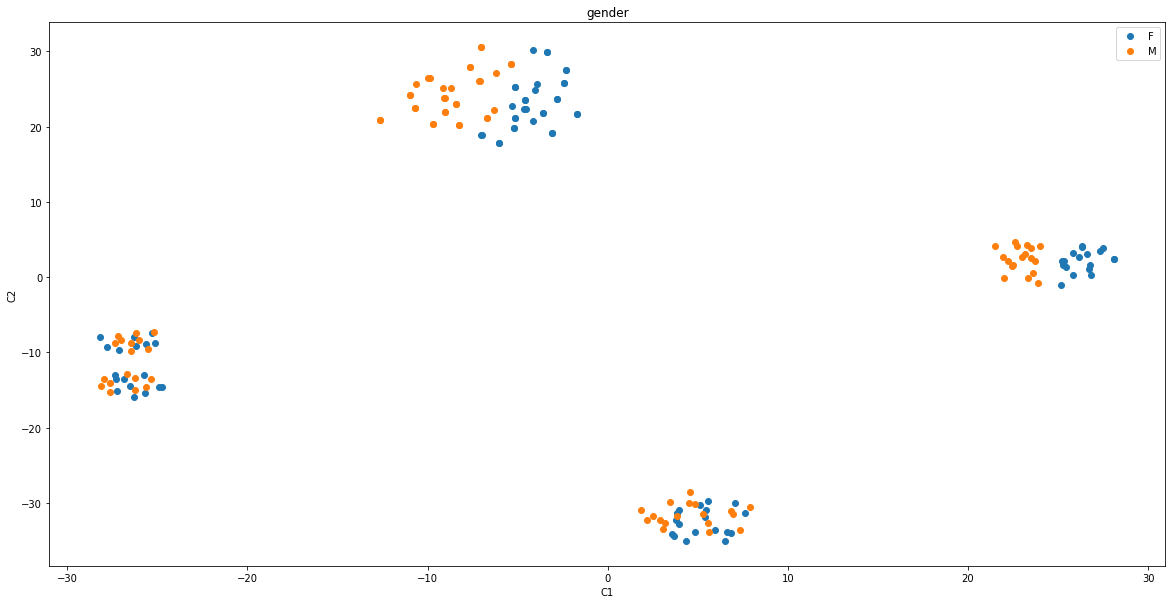

In [17]:
for c in combinations(range(n_components), 2):
    i1 = c[0]
    i2 = c[1]
    for group in groups:
        for subgroup, label in zip(groups[group], labels[group]):
            locs = np.isin(models, subgroup)
            plt.plot(comps[locs,i1], comps[locs,i2],"o", label=label)
            
        #for model, x, y in zip(models, comps[:,i1], comps[:,i2]):        
        #    plt.text(x+0.05,y+0.05,model)

        plt.title(group)
        plt.xlabel("C"+str(i1+1))#plt.xlabel("PC"+str(i1+1) + " (" + str(round(100*pca_explained[i1],2))+"%)")
        plt.ylabel("C"+str(i2+1))#plt.ylabel("PC"+str(i2+1) + " (" + str(round(100*pca_explained[i2],2))+"%)")
        plt.legend()
        plt.gcf().set_size_inches(20,10)
        plt.savefig("figures_tSNE_extended\\"+"C"+str(i1+1)+'_'+"C"+str(i2+1)+'_'+group+".pdf", format="pdf", bbox_inches = 'tight')
        plt.savefig("figures_tSNE_extended\\"+"C"+str(i1+1)+'_'+"C"+str(i2+1)+'_'+group+".png", format="png", bbox_inches = 'tight')
        plt.show()